In [1]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Preprocessing
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchinfo import summary

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# Path
from pathlib import Path

# OrderedDict
from collections import OrderedDict

# tqdm
from tqdm.auto import tqdm

# warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_PATH_IA = Path("/kaggle/input/dataset-of-ai-generated-fruits-and-real-fruits/Dataset of AI Generated Fruits and Real Fruits/Ai")

IMAGE_PATH_LIST_IA = list(IMAGE_PATH_IA.glob("*/*/*.jpg"))

print(f'Total Images IA = {len(IMAGE_PATH_LIST_IA)}')

Total Images IA = 150


In [4]:
llabels_ia = [None] * len(IMAGE_PATH_LIST_IA)

for i,img_path in enumerate(IMAGE_PATH_LIST_IA):
    labels_ia[i] = os.path.join(img_path.parent.parent.stem, img_path.parent.parent.parent.stem)

In [5]:
pd.Series(labels_ia).value_counts()

Red Apples/Ai      75
Green Apples/Ai    75
Name: count, dtype: int64

In [6]:
IMAGE_PATH_REAL = Path("/kaggle/input/dataset-of-ai-generated-fruits-and-real-fruits/Dataset of AI Generated Fruits and Real Fruits/Real")

IMAGE_PATH_LIST_REAL = list(IMAGE_PATH_REAL.glob("*/*/*.jpg"))

print(f'Total Images REAL = {len(IMAGE_PATH_LIST_REAL)}')

Total Images REAL = 156


In [7]:
labels_real = [None] * len(IMAGE_PATH_LIST_REAL)

for i,img_path in enumerate(IMAGE_PATH_LIST_REAL):
    labels_real[i] = os.path.join(img_path.parent.parent.stem, img_path.parent.parent.parent.stem)

In [8]:
pd.Series(labels_real).value_counts()

Red Apples/Real      79
Green Apples/Real    77
Name: count, dtype: int64

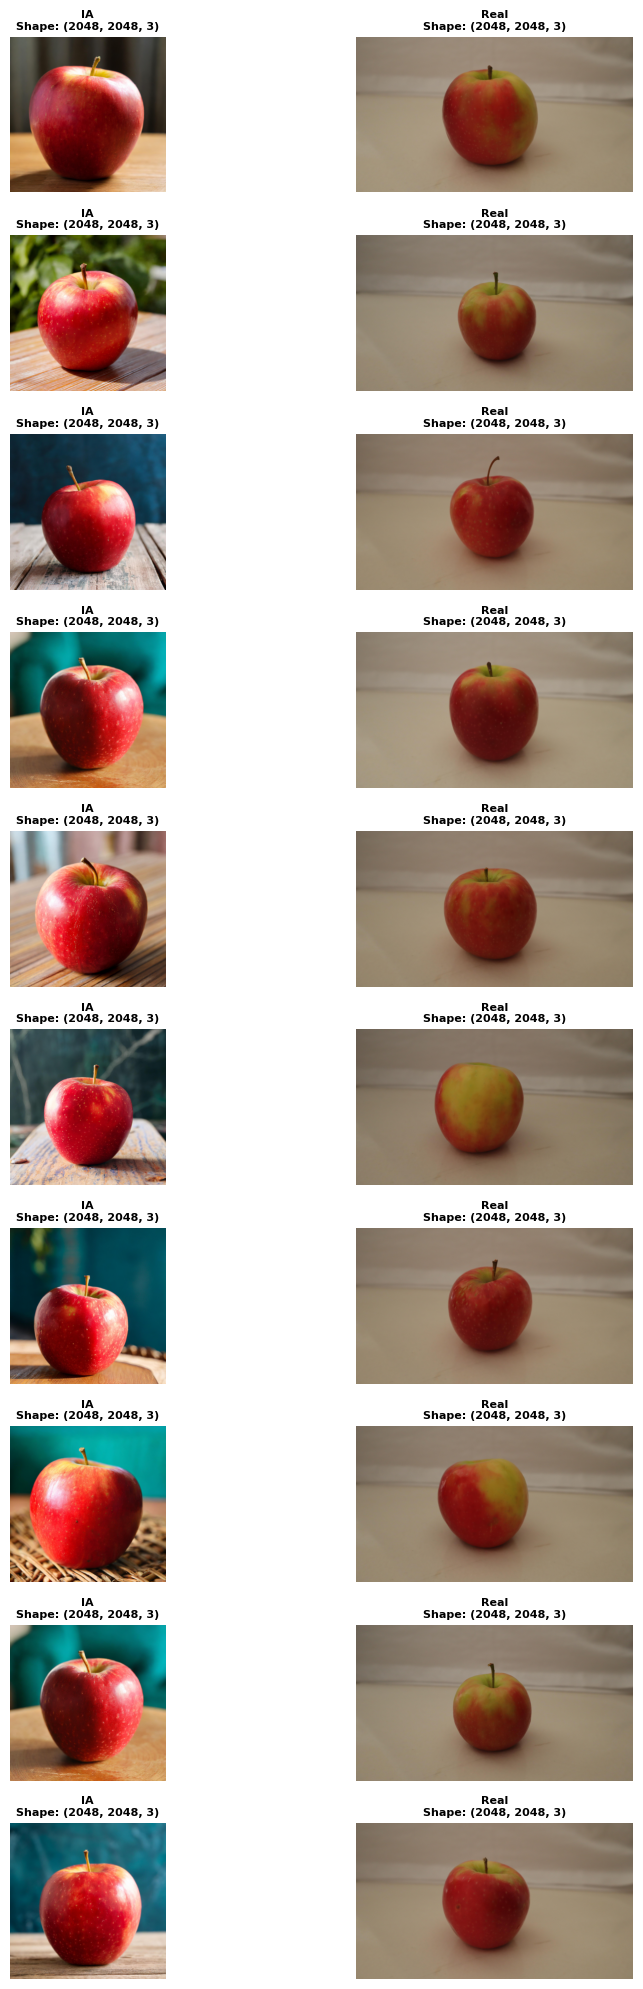

In [9]:
fig, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (10, 20))

for i,(img_ia,img_real) in enumerate(zip(IMAGE_PATH_LIST_IA, IMAGE_PATH_LIST_REAL)):
    if i > 9:
        break
        
    img_bgr_ia = cv2.imread(str(img_ia))
    img_rgb_ia = cv2.cvtColor(img_bgr_ia, cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(img_rgb_ia)
    ax[i,0].axis('off')
    ax[i,0].set_title(f"IA\nShape: {img_rgb_ia.shape}", fontsize = 8, fontweight = "bold")
    
    img_bgr_real = cv2.imread(str(img_real))
    img_rgb_real = cv2.cvtColor(img_bgr_real, cv2.COLOR_BGR2RGB)
    ax[i,1].imshow(img_rgb_real)
    ax[i,1].axis('off')
    ax[i,1].set_title(f"Real\nShape: {img_rgb_ia.shape}", fontsize = 8, fontweight = "bold")
    
fig.tight_layout()
fig.show()

In [10]:
data_ia = pd.DataFrame({'Path':IMAGE_PATH_LIST_IA, 'Label':labels_ia})
data_real = pd.DataFrame({'Path':IMAGE_PATH_LIST_REAL, 'Label':labels_real})

data = pd.concat((data_ia, data_real), axis = 0)
data.head()

,Path,Label
0,/kaggle/input/dataset-of-ai-generated-fruits-a...,Red Apples/Ai
1,/kaggle/input/dataset-of-ai-generated-fruits-a...,Red Apples/Ai
2,/kaggle/input/dataset-of-ai-generated-fruits-a...,Red Apples/Ai
3,/kaggle/input/dataset-of-ai-generated-fruits-a...,Red Apples/Ai
4,/kaggle/input/dataset-of-ai-generated-fruits-a...,Red Apples/Ai


In [11]:
data['Label'].value_counts()

Label
Red Apples/Real      79
Green Apples/Real    77
Red Apples/Ai        75
Green Apples/Ai      75
Name: count, dtype: int64

In [12]:
SEED = 123456

data_train, data_rest = tts(data, test_size = 0.3, random_state = SEED, stratify = data['Label'])

data_val, data_test = tts(data_rest, test_size = 0.5, random_state = SEED, stratify = data_rest['Label'])
CLASSES = data['Label'].unique()
CLASSES = sorted(CLASSES)
CLASSES

['Green Apples/Ai', 'Green Apples/Real', 'Red Apples/Ai', 'Red Apples/Real']

In [13]:
label2id = dict(zip(CLASSES, range(len(CLASSES))))
label2id

{'Green Apples/Ai': 0,
 'Green Apples/Real': 1,
 'Red Apples/Ai': 2,
 'Red Apples/Real': 3}

In [14]:
weights = ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [15]:
class CustomImageDataset(Dataset):
    def __init__(self, data:pd.DataFrame, label_map:dict, image_transforms):
        self.data = data
        self.label_map = label_map
        self.image_transforms = image_transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_new = self.data.copy()
        data_new['Label'] = data_new['Label'].map(self.label_map)
        
        image_path = data_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)
        
        target = data_new.iloc[idx, 1]
        
        return image, target
    

In [16]:
train_dataset = CustomImageDataset(data_train, label2id, auto_transforms)
val_dataset = CustomImageDataset(data_val, label2id, auto_transforms)

In [17]:
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset = val_dataset, 
                            batch_size = BATCH_SIZE, 
                            shuffle = True, 
                            num_workers = NUM_WORKERS)

In [18]:
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [19]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [20]:
model = vit_b_16(weights = weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 277MB/s]  


In [21]:
summary(model = model, input_size = [8,3,224,224], col_width  =15, 
        col_names = ['input_size', 'output_size','num_params','trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [8, 3, 224, 224] [8, 1000]       768             True
├─Conv2d (conv_proj)                                         [8, 3, 224, 224] [8, 768, 14, 14] 590,592         True
├─Encoder (encoder)                                          [8, 197, 768]   [8, 197, 768]   151,296         True
│    └─Dropout (dropout)                                     [8, 197, 768]   [8, 197, 768]   --              --
│    └─Sequential (layers)                                   [8, 197, 768]   [8, 197, 768]   --              True
│    │    └─EncoderBlock (encoder_layer_0)                   [8, 197, 768]   [8, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_1)                   [8, 197, 768]   [8, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_2)                   [8, 197, 768]   [8, 1

In [22]:
for param in model.conv_proj.parameters():
    param.requires_grad = False

In [23]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [24]:
summary(model = model, input_size = [8,3,224,224], col_width  =15, 
        col_names = ['input_size', 'output_size','num_params','trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [8, 3, 224, 224] [8, 1000]       768             Partial
├─Conv2d (conv_proj)                                         [8, 3, 224, 224] [8, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [8, 197, 768]   [8, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [8, 197, 768]   [8, 197, 768]   --              --
│    └─Sequential (layers)                                   [8, 197, 768]   [8, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [8, 197, 768]   [8, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [8, 197, 768]   [8, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [8, 197, 768]

In [25]:
output_shape = len(CLASSES)

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768, out_features = output_shape))]))

In [26]:
# Finally, let's see if the last layer was modified.
summary(model = model, input_size = [8,3,224,224], col_width  =15, 
        col_names = ['input_size', 'output_size','num_params','trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [8, 3, 224, 224] [8, 4]          768             Partial
├─Conv2d (conv_proj)                                         [8, 3, 224, 224] [8, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [8, 197, 768]   [8, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [8, 197, 768]   [8, 197, 768]   --              --
│    └─Sequential (layers)                                   [8, 197, 768]   [8, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [8, 197, 768]   [8, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [8, 197, 768]   [8, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [8, 197, 768]

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.0001)

In [28]:
class EarlyStopping:
    def __init__(self, patience:int = 10, delta:float = 0.0001, path:str = "best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [29]:
early_stopping = EarlyStopping(patience = 10, delta = 0.)

In [30]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0
    train_accuracy = 0
    
    for batch,(X,y) in enumerate(dataloader):
        X = X.to(device = DEVICE, dtype = torch.float32)
        y = y.to(device = DEVICE, dtype = torch.long)
        
        optimizer.zero_grad()
        
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        y_pred_prob = y_pred_logit.softmax(dim = 1)
        y_pred_class = y_pred_prob.argmax(dim = 1)
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
        
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    
    return train_loss, train_accuracy

In [31]:
def val_step(model:torch.nn.Module, 
             dataloader:torch.utils.data.DataLoader, 
             loss_fn:torch.nn.Module):
    
    model.eval()
    
    val_loss = 0
    val_accuracy = 0
    
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y = y.to(device = DEVICE, dtype = torch.long)
            
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            val_loss += loss.item()
            
            y_pred_prob = y_pred_logit.softmax(dim = 1)
            y_pred_class = y_pred_prob.argmax(dim = 1)
            val_accuracy += accuracy_score(y.cpu().numpy(), 
                                                    y_pred_class.detach().cpu().numpy())
            
    val_loss = val_loss / len(dataloader)
    val_accuracy = val_accuracy / len(dataloader)
    
    return val_loss, val_accuracy

In [32]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader, 
          val_datalaoder:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, early_stopping, epochs:int = 10):
    
    results = {'train_loss':[], 'train_accuracy':[], 'val_loss':[], 'val_accuracy':[]}
    
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_accuracy = train_step(model = model, dataloader = train_dataloader, 
                                                loss_fn = loss_fn, optimizer = optimizer)
        
        val_loss, val_accuracy = val_step(model = model, dataloader = val_dataloader, 
                                          loss_fn = loss_fn)
        
        print(f'Epoch: {epoch + 1} | ', 
              f'Train Loss: {train_loss:.4f} | ', 
              f'Train Accuracy: {train_accuracy:.4f} | ', 
              f'Val Loss: {val_loss:.4f} | ', 
              f'Val Accuracy: {val_accuracy:.4f}')
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop == True:
            print("Early Stopping!!")
            break
            
        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['val_loss'].append(val_loss)
        results['val_accuracy'].append(val_accuracy)
        
    return results

In [33]:
EPOCHS = 50

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device = DEVICE), train_dataloader, val_dataloader, loss_fn, optimizer, early_stopping, EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.4982 |  Train Accuracy: 0.8148 |  Val Loss: 0.0205 |  Val Accuracy: 1.0000
Epoch: 2 |  Train Loss: 0.0153 |  Train Accuracy: 0.9954 |  Val Loss: 0.0076 |  Val Accuracy: 1.0000
Epoch: 3 |  Train Loss: 0.0046 |  Train Accuracy: 1.0000 |  Val Loss: 0.0037 |  Val Accuracy: 1.0000
Epoch: 4 |  Train Loss: 0.0019 |  Train Accuracy: 1.0000 |  Val Loss: 0.0015 |  Val Accuracy: 1.0000
Epoch: 5 |  Train Loss: 0.0013 |  Train Accuracy: 1.0000 |  Val Loss: 0.0014 |  Val Accuracy: 1.0000
Epoch: 6 |  Train Loss: 0.0009 |  Train Accuracy: 1.0000 |  Val Loss: 0.0009 |  Val Accuracy: 1.0000
Epoch: 7 |  Train Loss: 0.0006 |  Train Accuracy: 1.0000 |  Val Loss: 0.0007 |  Val Accuracy: 1.0000
Epoch: 8 |  Train Loss: 0.0004 |  Train Accuracy: 1.0000 |  Val Loss: 0.0005 |  Val Accuracy: 1.0000
Epoch: 9 |  Train Loss: 0.0004 |  Train Accuracy: 1.0000 |  Val Loss: 0.0004 |  Val Accuracy: 1.0000
Epoch: 10 |  Train Loss: 0.0003 |  Train Accuracy: 1.0000 |  Val Loss: 0.0004 |  Val Accura

In [34]:
def metric_and_loss_plot(results:dict):
    
    training_loss = results['train_loss']
    training_accuracy = results['train_accuracy']
    
    valid_loss = results['val_loss']
    valid_accuracy = results['val_accuracy']
    
    fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    ax = ax.flat
    
    ax[0].plot(training_loss, color = "red", label = "Train")
    ax[0].plot(valid_loss, color = "blue", label = "Valid")
    ax[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    ax[0].set_xlabel("Epoch", fontsize = 10, fontweight = "bold", color = "black")
    ax[0].set_ylabel("loss", fontsize = 10, fontweight = "bold", color = "black")
    
    ax[1].plot(training_accuracy, color = "red", label = "Train")
    ax[1].plot(valid_accuracy, color = "blue", label = "Valid")
    ax[1].set_title("Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    ax[1].set_xlabel("Epoch", fontsize = 10, fontweight = "bold", color = "black")
    ax[1].set_ylabel("score", fontsize = 10, fontweight = "bold", color = "black")
    
    ax[0].legend()
    ax[1].legend()
    fig.tight_layout()
    fig.show()

In [35]:
def predictions(test_dataloader:torch.utils.data.DataLoader):
    
    checkpoint = torch.load("best_model.pth")
    
    loaded_model = vit_b_16()
    
    loaded_model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768, 
                                                                       out_features = output_shape))]))
    
    loaded_model.load_state_dict(checkpoint)
    
    loaded_model.to(device = DEVICE)
    
    loaded_model.eval()
    
    y_pred_test = []
    
    with torch.inference_mode():
        
        for X,_ in tqdm(test_dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y_pred_logit = loaded_model(X)
            y_pred_prob = y_pred_logit.softmax(dim = 1)
            y_pred_class = y_pred_prob.argmax(dim = 1)
            y_pred_test.append(y_pred_class.detach().cpu())
            
    y_pred_test = torch.cat(y_pred_test)
    
    return y_pred_test

In [36]:
# We create our Dataset and DataLoader.
test_dataset = CustomImageDataset(data_test, label2id, auto_transforms)

test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, 
                             shuffle = False, num_workers = NUM_WORKERS)

In [37]:
y_pred_test = predictions(test_dataloader)

  0%|          | 0/6 [00:00<?, ?it/s]

In [38]:
test_accuracy = balanced_accuracy_score(data_test['Label'].map(label2id), y_pred_test.numpy())

print(f"Balanced Accuracy Test = {test_accuracy:.4f}")

NameError: name 'balanced_accuracy_score' is not defined

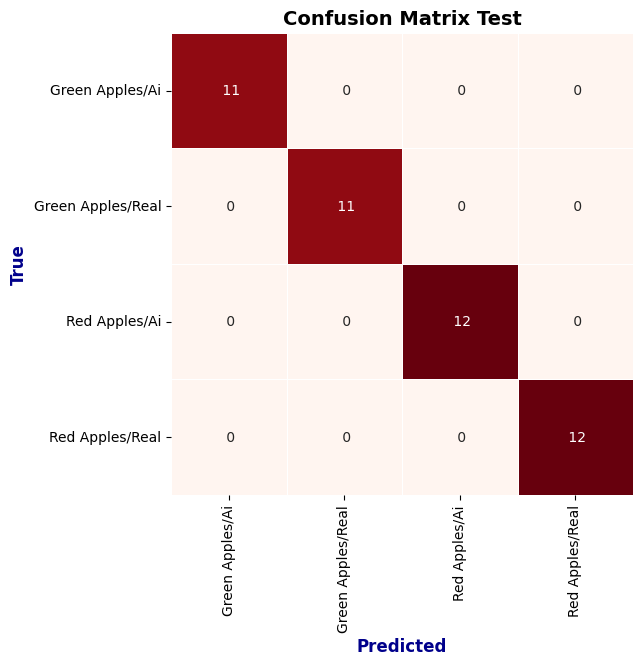

In [39]:
cf_mx_test = confusion_matrix(data_test['Label'].map(label2id), y_pred_test.numpy())

fig,ax = plt.subplots(figsize = (6,6))
sns.heatmap(cf_mx_test, cmap = 'Reds', fmt = ' ', annot = True, cbar = False, square = True, linewidths = 0.4,
            xticklabels = CLASSES, yticklabels = CLASSES, ax = ax)
ax.set_ylabel("True", color = "darkblue", fontsize = 12, fontweight = "bold")
ax.set_xlabel("Predicted", color = "darkblue", fontsize = 12, fontweight = "bold")
ax.set_title("Confusion Matrix Test", fontsize = 14, fontweight = "bold", color = "black")

fig.show()
